In [12]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

os.chdir('..')

In [13]:
# iTransformer Traffic args configuration (96 -> 192)
# Build full args by merging run.py defaults with script overrides.

# Defaults copied from run.py add_argument declarations
default_config = {
    # basic config
    "task_name": "long_term_forecast",
    "is_training": 1,
    "model_id": "test",
    "model": "Autoformer",

    # data loader
    "data": "ETTh1",
    "root_path": "./data/ETT/",
    "data_path": "ETTh1.csv",
    "features": "M",
    "target": "OT",
    "freq": "h",
    "checkpoints": "./checkpoints/",

    # forecasting task
    "seq_len": 96,
    "label_len": 48,
    "pred_len": 96,
    "seasonal_patterns": "Monthly",
    "inverse": False,

    # imputation task
    "mask_rate": 0.25,

    # anomaly detection task
    "anomaly_ratio": 0.25,

    # model define
    "expand": 2,
    "d_conv": 4,
    "top_k": 5,
    "num_kernels": 6,
    "enc_in": 7,
    "dec_in": 7,
    "c_out": 7,
    "d_model": 512,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 2048,
    "moving_avg": 25,
    "factor": 1,
    "distil": True,
    "dropout": 0.1,
    "embed": "timeF",
    "activation": "gelu",
    "channel_independence": 1,
    "decomp_method": "moving_avg",
    "use_norm": 1,
    "down_sampling_layers": 0,
    "down_sampling_window": 1,
    "down_sampling_method": None,
    "seg_len": 96,

    # optimization
    "num_workers": 10,
    "itr": 1,
    "train_epochs": 10,
    "batch_size": 32,
    "patience": 3,
    "learning_rate": 0.0001,
    "des": "test",
    "loss": "MSE",
    "lradj": "type1",
    "use_amp": False,

    # GPU
    "use_gpu": True,
    "gpu": 0,
    "gpu_type": "cuda",
    "use_multi_gpu": False,
    "devices": "0,1,2,3",

    # de-stationary projector params
    "p_hidden_dims": [128, 128],
    "p_hidden_layers": 2,

    # metrics (dtw)
    "use_dtw": False,

    # Augmentation
    "augmentation_ratio": 0,
    "seed": 2,
    "jitter": False,
    "scaling": False,
    "permutation": False,
    "randompermutation": False,
    "magwarp": False,
    "timewarp": False,
    "windowslice": False,
    "windowwarp": False,
    "rotation": False,
    "spawner": False,
    "dtwwarp": False,
    "shapedtwwarp": False,
    "wdba": False,
    "discdtw": False,
    "discsdtw": False,
    "extra_tag": "",

    # TimeXer
    "patch_len": 16,
}

# Overrides from scripts/long_term_forecast/Traffic_script/iTransformer.sh (active block)
script_overrides = {
    "task_name": "long_term_forecast",
    "is_training": 1,
    "root_path": "/home/hycai/workspace/timeseries/Time-Series-Library/dataset/traffic",
    "data_path": "traffic.csv",
    "model_id": "traffic_96_192",
    "model": "iTransformer",
    "data": "custom",
    "features": "M",
    "seq_len": 96,
    "label_len": 48,
    "pred_len": 192,
    "e_layers": 4,
    "d_layers": 1,
    "factor": 3,
    "enc_in": 862,
    "dec_in": 862,
    "c_out": 862,
    "des": "Exp",
    "d_model": 512,
    "d_ff": 512,
    "batch_size": 16,
    "learning_rate": 0.001,
    "itr": 1,
}

# Merge: if a key isn't in the script, keep run.py default
args_config = {**default_config, **script_overrides}

# Optional: convert to an argparse-like Namespace for convenience
try:
    from argparse import Namespace
    args = Namespace(**args_config)
except Exception:
    class Namespace:
        def __init__(self, **kwargs):
            self.__dict__.update(kwargs)
    args = Namespace(**args_config)

# Show keys that differ from defaults (for quick verification)
changed = {k: (default_config.get(k), args_config[k]) for k in args_config if default_config.get(k) != args_config[k]}
print("Overridden keys (default -> using):")
for k in sorted(changed.keys()):
    print(f"- {k}: {changed[k][0]} -> {changed[k][1]}")


Overridden keys (default -> using):
- batch_size: 32 -> 16
- c_out: 7 -> 862
- d_ff: 2048 -> 512
- data: ETTh1 -> custom
- data_path: ETTh1.csv -> traffic.csv
- dec_in: 7 -> 862
- des: test -> Exp
- e_layers: 2 -> 4
- enc_in: 7 -> 862
- factor: 1 -> 3
- learning_rate: 0.0001 -> 0.001
- model: Autoformer -> iTransformer
- model_id: test -> traffic_96_192
- pred_len: 96 -> 192
- root_path: ./data/ETT/ -> /home/hycai/workspace/timeseries/Time-Series-Library/dataset/traffic


In [14]:

from data_provider.data_factory import data_provider
data_set, data_loader = data_provider(args, flag='train')

train 11993


In [15]:
sample = next(iter(data_loader))
sample[0].shape

smaple_x = sample[0][0, :, 0].numpy()
sample_y = sample[1][0, :, 0].numpy()

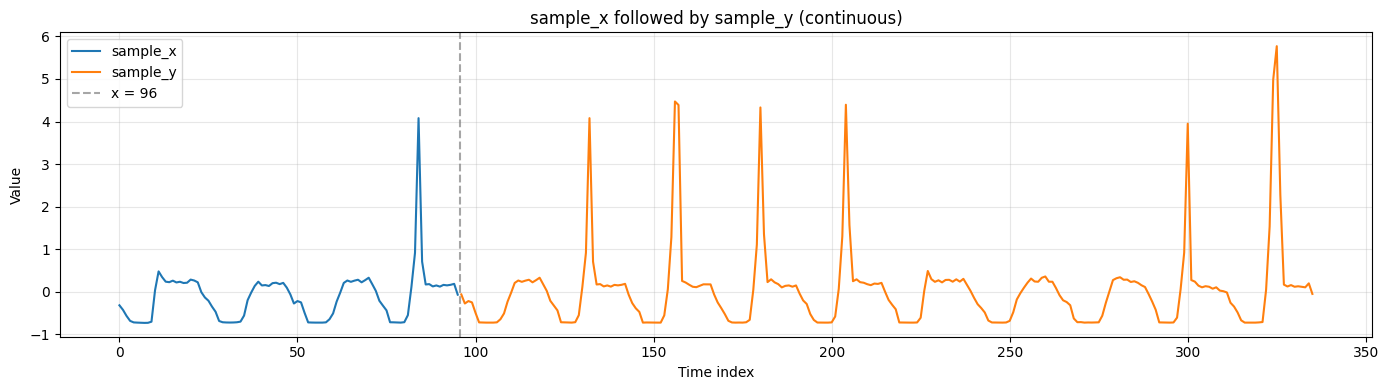

In [16]:
# concatenate and plot sample_x then sample_y as one continuous series
boundary = len(smaple_x)
plt.figure(figsize=(14, 4))
plt.plot(np.arange(0, boundary), smaple_x, color='tab:blue', label='sample_x', linewidth=1.5)
plt.plot(np.arange(boundary, boundary + len(sample_y)), sample_y, color='tab:orange', label='sample_y', linewidth=1.5)
plt.axvline(boundary - 0.5, color='gray', linestyle='--', alpha=0.7, label=f'x = {boundary}')
plt.xlabel('Time index')
plt.ylabel('Value')
plt.title('sample_x followed by sample_y (continuous)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Optional, Sequence


class MultiScaleDownsampler(nn.Module):
    """
    Multi-scale temporal downsampling for time series.

    Input:  x of shape (batch_size, seq_len, dim)
    Output: list of tensors, one per scale: [x_s1, x_s2, ..., x_sn]
            where each x_si has shape (batch_size, new_len_i, dim)

    Args:
        n_scales: Number of different temporal scales to generate.
        mode: Downsampling method. One of {"avg", "max", "conv"}.
              - "avg": Average pooling over time.
              - "max": Max pooling over time.
              - "conv": Depthwise 1D convolution with stride=factor using
                         a fixed average kernel (low-pass like). Preserves feature
                         dimension (depthwise), supports ceil_mode via right padding.
        scale_factors: Optional explicit list of integer downsampling factors
                       (length must equal n_scales). If None, factors will be
                       powers of `scale_base`: [scale_base**1, ..., scale_base**n_scales].
        scale_base: Base used to generate powers when `scale_factors` is None. Default 2.
        ceil_mode: When True, use ceil in output shape computation and pad end if needed.
                   Helps keep at least 1 output step even when seq_len < factor.
    Notes:
        - Time dimension is downsampled; feature dimension is preserved.
        - If seq_len is not divisible by the factor, the tail is handled based on ceil_mode.
    """

    def __init__(
        self,
        n_scales: int,
        mode: str = "avg",
        scale_factors: Optional[Sequence[int]] = None,
        scale_base: int = 2,
        ceil_mode: bool = True,
    ) -> None:
        super().__init__()
        assert n_scales >= 1, "n_scales must be >= 1"
        mode = mode.lower()
        assert mode in {"avg", "max", "conv"}, "mode must be 'avg', 'max' or 'conv'"

        if scale_factors is not None:
            assert len(scale_factors) == n_scales, "scale_factors length must equal n_scales"
            for f in scale_factors:
                assert isinstance(f, int) and f >= 1, "each scale factor must be an integer >= 1"
            self.scale_factors = list(scale_factors)
        else:
            assert isinstance(scale_base, int) and scale_base >= 2, "scale_base must be integer >= 2"
            # factors: base^1, base^2, ..., base^n
            self.scale_factors = [scale_base ** i for i in range(1, n_scales + 1)]

        self.n_scales = n_scales
        self.mode = mode
        self.ceil_mode = ceil_mode

    @staticmethod
    def _compute_right_pad(L: int, k: int, s: int) -> int:
        """Compute minimal right padding so that L_out == ceil(L / s)
        for conv1d with kernel k, stride s, no left padding.
        """
        import math
        target = math.ceil(L / s)
        pad_right = max(0, (target - 1) * s + k - L)
        return pad_right

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:
        """
        Args:
            x: Tensor of shape (B, L, D)
        Returns:
            List[Tensor]: length n_scales; each tensor is (B, L_i, D)
        """
        if x.dim() != 3:
            raise ValueError(f"Expected input of shape (B, L, D), got {tuple(x.shape)}")
        B, L, D = x.shape
        # to (B, D, L) for 1D pooling/conv over time
        x_c = x.permute(0, 2, 1)

        outs: List[torch.Tensor] = []
        for f in self.scale_factors:
            if f == 1:
                # no downsampling, passthrough
                y = x_c
            else:
                if self.mode == "avg":
                    y = F.avg_pool1d(x_c, kernel_size=f, stride=f, ceil_mode=self.ceil_mode)
                elif self.mode == "max":
                    y = F.max_pool1d(x_c, kernel_size=f, stride=f, ceil_mode=self.ceil_mode)
                else:  # "conv" depthwise average filter with stride
                    k = f  # kernel size equals stride to mimic pooling-like downsample
                    if self.ceil_mode:
                        pad_right = self._compute_right_pad(L, k, f)
                        x_in = F.pad(x_c, (0, pad_right))  # pad on the right along time dim
                    else:
                        x_in = x_c
                    # depthwise average kernel: (D, 1, k)
                    weight = torch.full((D, 1, k), 1.0 / float(k), dtype=x.dtype, device=x.device)
                    y = F.conv1d(x_in, weight, bias=None, stride=f, padding=0, groups=D)
            # back to (B, L', D)
            y = y.permute(0, 2, 1).contiguous()
            outs.append(y)
        return outs


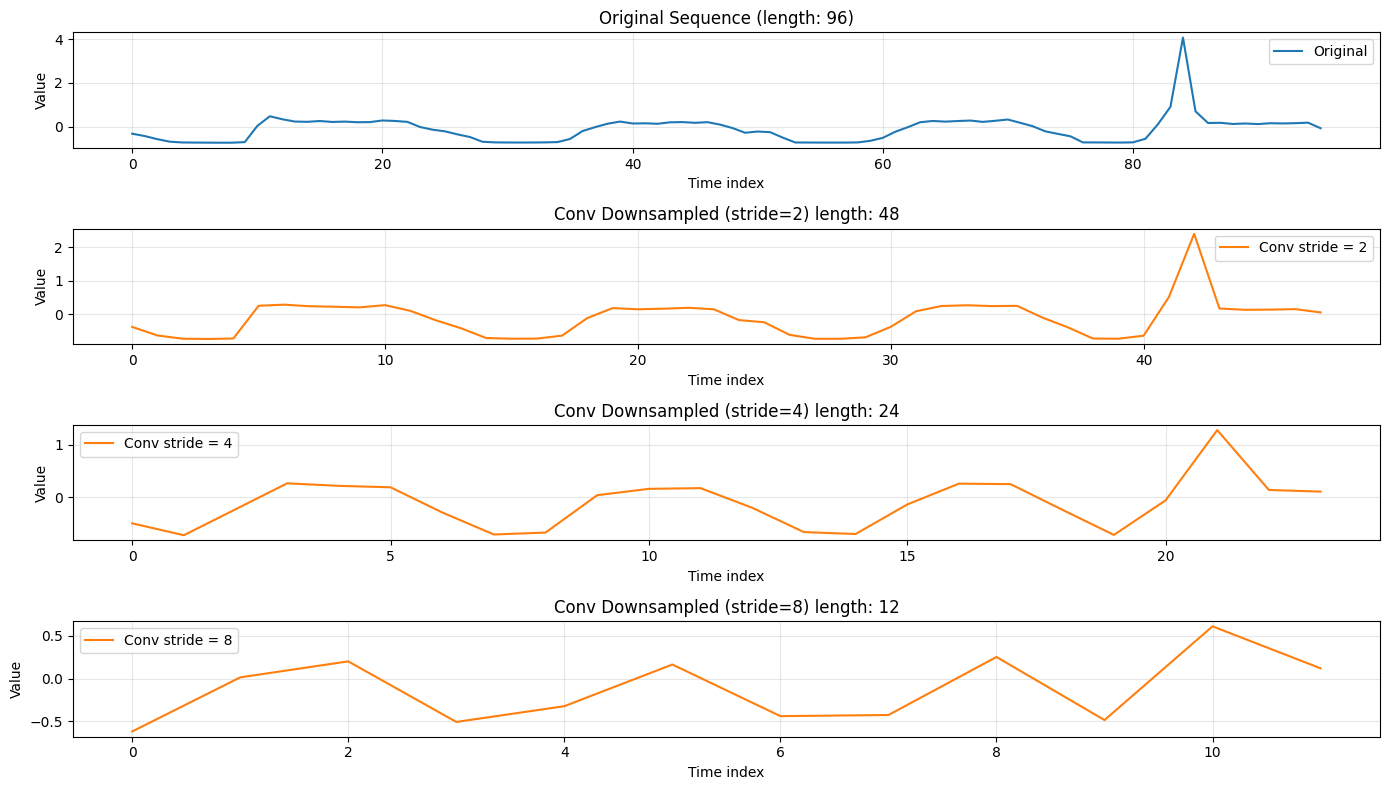

In [18]:
# Instantiate the MultiScaleDownsampler with strided conv (e.g., 3 scales)
downsampler = MultiScaleDownsampler(n_scales=3, mode='conv')

# Convert smaple_x to torch tensor with shape (1, 96, 1)
x = torch.tensor(smaple_x).unsqueeze(0).unsqueeze(-1)

# Perform downsampling
outs = downsampler(x)

# Plot each downsampled sequence
plt.figure(figsize=(14, 8))
for i, out in enumerate([x] + outs):
    # Squeeze to (L_i,) for plotting
    seq = out.squeeze().numpy()
    plt.subplot(len([x] + outs), 1, i+1)
    if i == 0:
        plt.plot(seq, label='Original', color='tab:blue')
        plt.title(f'Original Sequence (length: {len(seq)})')
    else:
        plt.plot(seq, label=f'Conv stride = {downsampler.scale_factors[i-1]}', color='tab:orange')
        plt.title(f'Conv Downsampled (stride={downsampler.scale_factors[i-1]}) length: {len(seq)}')
    plt.xlabel('Time index')
    plt.ylabel('Value')
    plt.grid(alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

In [21]:
batch_outs = downsampler(sample[0])

print(len(batch_outs))
print(batch_outs[0].shape)
print(batch_outs[1].shape)
print(batch_outs[2].shape)

3
torch.Size([16, 48, 862])
torch.Size([16, 24, 862])
torch.Size([16, 12, 862])


In [28]:
# Multi-Scale Length MLP: learnable mapping along time dimension to a unified length (preserve D)
import torch
import torch.nn as nn
from typing import List, Optional, Sequence


class MultiScaleLengthMLP(nn.Module):
    """
    Map each scale's temporal dimension L_i to a unified target_len using a learnable
    linear projection along time, while preserving the feature dimension D.

    Inputs:  list xs, each x with shape (B, L_i, D)
    Outputs: list ys, each y with shape (B, target_len, D)

    For each scale i, and each feature channel d, apply a Linear(L_i -> target_len)
    to the time series (length axis), optionally with a nonlinearity.

    Notes:
      - Different scales can have different input lengths L_i; this module lazily creates
        one mapper per (scale index, input length). If you prefer static construction,
        pass scale_lengths at init.
    """
    def __init__(
        self,
        n_scales: int,
        target_len: int,
        activation: str = 'gelu',
        dropout: float = 0.0,
        scale_lengths: Optional[Sequence[int]] = None,
    ) -> None:
        super().__init__()
        assert n_scales >= 1 and target_len >= 1
        self.n_scales = n_scales
        self.target_len = target_len
        self._act_name = activation.lower()
        self._dropout = dropout

        # Store static mappers if input lengths are known; else lazily add to ModuleDict
        self.mappers = nn.ModuleDict()
        if scale_lengths is not None:
            assert len(scale_lengths) == n_scales
            for i, L in enumerate(scale_lengths):
                self.mappers[self._key(i, L)] = self._make_mapper(L)

    def _make_mapper(self, L: int) -> nn.Sequential:
        act = nn.GELU() if self._act_name == 'gelu' else nn.ReLU()
        return nn.Sequential(
            nn.Linear(L, self.target_len),
            act,
            nn.Dropout(self._dropout),
        )

    @staticmethod
    def _key(i: int, L: int) -> str:
        return f"scale{i}_L{L}"

    def forward(self, xs: List[torch.Tensor]) -> List[torch.Tensor]:
        assert len(xs) == self.n_scales, f"Expected {self.n_scales} scales, got {len(xs)}"
        ys: List[torch.Tensor] = []
        ref_D = None
        for i, x in enumerate(xs):
            if x.dim() != 3:
                raise ValueError(f"Scale {i} must be (B, L_i, D), got {tuple(x.shape)}")
            B, L, D = x.shape
            if ref_D is None:
                ref_D = D
            else:
                if D != ref_D:
                    raise ValueError(f"All scales must share the same feature dim. Got {D} vs {ref_D} at scale {i}.")

            key = self._key(i, L)
            if key not in self.mappers:
                # Lazily create per-scale mapper and move to x's device/dtype
                mapper = self._make_mapper(L).to(device=x.device, dtype=x.dtype)
                self.mappers[key] = mapper
            mapper = self.mappers[key]

            # Apply Linear(L->target_len) per feature channel and batch item
            # reshape (B, L, D) -> (B, D, L) -> (B*D, L)
            p = x.permute(0, 2, 1).contiguous().view(B * D, L)
            # match dtype/device with mapper weights
            p = p.to(device=mapper[0].weight.device, dtype=mapper[0].weight.dtype)
            q = mapper(p)  # (B*D, target_len)
            q = q.view(B, D, self.target_len).permute(0, 2, 1).contiguous()  # (B, target_len, D)
            ys.append(q)
        return ys


In [34]:
# Demo: learnable length mapping with MLP (preserve feature dim)
# 1) Single-sample (1, 96, 1) from earlier 'outs'
mapper_single = MultiScaleLengthMLP(
    n_scales=len(outs), target_len=128, activation='gelu', dropout=0.0
)
feats_single = mapper_single(outs)
print("Single-sample scales ->", [t.shape for t in feats_single])

# 2) Batch example using 'batch_outs' from the dataloader
mapper_batch = MultiScaleLengthMLP(
    n_scales=len(batch_outs), target_len=128, activation='gelu', dropout=0.0
)
feats_batch = mapper_batch(batch_outs)
print("Batch scales ->", [t.shape for t in feats_batch])

# Optional simple fusion preview (mean across scales, keep (B, T, D))
import torch
stacked = torch.stack(feats_batch, dim=1)  # (B, S, T, D)
fused_mean = stacked.mean(dim=1)  # (B, T, D)
print("Fused (mean) shape:", fused_mean.shape)

Single-sample scales -> [torch.Size([1, 128, 1]), torch.Size([1, 128, 1]), torch.Size([1, 128, 1])]
Batch scales -> [torch.Size([16, 128, 862]), torch.Size([16, 128, 862]), torch.Size([16, 128, 862])]
Fused (mean) shape: torch.Size([16, 128, 862])


In [40]:
# Attention-weighted multi-scale fusion: Linear->Softmax over scales, weighted sum to fuse
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Optional


class MultiScaleAttentionFuser(nn.Module):
    """
    Fuse time-aligned multi-scale sequences using attention weights over the scale axis.

    Inputs:  list xs of length S, each tensor shape (B, T, D) with same T and D
    Output:  fused tensor of shape (B, T, D_out) where D_out == D if out_dim is None else out_dim

    Mechanism:
      - Stack -> (B, S, T, D)
      - Per (scale, time) compute a logit via Linear(D->1) [initialized lazily on first forward]
      - Softmax over S (optionally with temperature) to obtain weights
      - Weighted sum over S to produce fused output (B, T, D)
      - Optional post projection Linear(D->D_out) if out_dim is provided

    Args:
      n_scales: number of scales
      out_dim:  optional output feature dimension after fusion; if None, keep D
      temperature: softmax temperature (>0); lower -> sharper weights
      dropout: optional dropout applied to logits before softmax
    """
    def __init__(self, n_scales: int, out_dim: Optional[int] = None, temperature: float = 1.0, dropout: float = 0.0) -> None:
        super().__init__()
        assert n_scales >= 1
        assert temperature > 0.0
        self.n_scales = n_scales
        self.temperature = temperature
        self.out_dim = out_dim
        self.scorer: Optional[nn.Linear] = None  # D -> 1, lazy
        self.out_proj: Optional[nn.Linear] = None  # D -> out_dim, lazy
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self._scorer_in_dim: Optional[int] = None
        self._proj_in_dim: Optional[int] = None

    def _maybe_init(self, in_dim: int, device: torch.device, dtype: torch.dtype):
        if self.scorer is None or self._scorer_in_dim != in_dim:
            self.scorer = nn.Linear(in_dim, 1, bias=True).to(device=device, dtype=dtype)
            self._scorer_in_dim = in_dim
        if self.out_dim is not None and (self.out_proj is None or self._proj_in_dim != in_dim):
            self.out_proj = nn.Linear(in_dim, self.out_dim, bias=True).to(device=device, dtype=dtype)
            self._proj_in_dim = in_dim

    def forward(self, xs: List[torch.Tensor], return_weights: bool = False):
        assert len(xs) == self.n_scales, f"Expected {self.n_scales} scales, got {len(xs)}"
        # Validate shapes and stack
        B = T = D = None
        for i, x in enumerate(xs):
            if x.dim() != 3:
                raise ValueError(f"Scale {i} must be (B, T, D), got {tuple(x.shape)}")
            if B is None:
                B, T, D = x.shape
            else:
                if x.shape != (B, T, D):
                    raise ValueError(f"All scales must share shape (B,T,D). Got {tuple(x.shape)} vs {(B,T,D)} at scale {i}.")
        X = torch.stack(xs, dim=1)  # (B, S, T, D)

        # Initialize scorer/proj lazily with correct device/dtype
        device = X.device
        dtype = X.dtype
        self._maybe_init(D, device, dtype)

        # Compute logits per (scale, time)
        logits = self.scorer(X).squeeze(-1)  # (B, S, T)
        logits = self.dropout(logits)
        weights = F.softmax(logits / self.temperature, dim=1)  # (B, S, T)

        # Weighted sum over scales -> (B, T, D)
        fused = (weights.unsqueeze(-1) * X).sum(dim=1)

        # Optional out projection
        if self.out_proj is not None:
            fused = self.out_proj(fused)

        return (fused, weights) if return_weights else fused

In [42]:
# Demo: attention fusion on MLP-mapped features (feats_batch)
# Ensure feats_batch exists (run previous cell if needed)
fuser = MultiScaleAttentionFuser(
    n_scales=len(feats_batch),
    out_dim=feats_batch[0].shape[-1],  # keep same feature size; set to another int to change output dim
    temperature=1.0,
    dropout=0.0,
)
fused, weights = fuser(feats_batch, return_weights=True)
print("Fused shape:", fused.shape)
print("Weights shape:", weights.shape)  # (B, S, T)

# Inspect first sample's weights across scales at a few time steps
b0 = 0
for t in [0, min(5, weights.shape[-1]-1), min(10, weights.shape[-1]-1)]:
    w = weights[b0, :, t].detach().cpu().numpy()
    print(f"t={t} weights:", w)

Fused shape: torch.Size([16, 128, 862])
Weights shape: torch.Size([16, 3, 128])
t=0 weights: [0.31980552 0.35264648 0.32754801]
t=5 weights: [0.31914767 0.34309087 0.33776146]
t=10 weights: [0.30620668 0.33082798 0.36296534]


In [44]:
multi_scale_input_generator = nn.Sequential(
            MultiScaleDownsampler(n_scales=3, mode='conv'),
            MultiScaleLengthMLP(n_scales=3, target_len=96, activation='gelu', dropout=0.3),
            MultiScaleAttentionFuser(n_scales=3, out_dim=512, temperature=0.5, dropout=0.3)
        )  

In [41]:
# Sanity test: lazy in_dim + optional out_dim
import torch

B, T, D_in, S, D_out = 2, 24, 16, 3, 8
xs = [torch.randn(B, T, D_in) for _ in range(S)]
fuser_test = MultiScaleAttentionFuser(n_scales=S, out_dim=D_out, temperature=0.7, dropout=0.1)
y, w = fuser_test(xs, return_weights=True)
print("Test fused shape:", tuple(y.shape))      # expect (2, 24, 8)
print("Test weights shape:", tuple(w.shape))    # expect (2, 3, 24)

Test fused shape: (2, 24, 8)
Test weights shape: (2, 3, 24)


In [46]:
x_out = multi_scale_input_generator(sample[0])

In [48]:
x_out.shape

torch.Size([16, 96, 512])

In [49]:
# Time conditioning with FiLM: use timestamp features (B,L,4) to modulate value features (B,L,D)
import torch
import torch.nn as nn
from typing import Optional

class TimeFiLM(nn.Module):
    """
    FiLM conditioning over time using timestamp features.

    Inputs:
      x: (B, L, D) value features
      t: (B, L, 4) timestamp features (e.g., [year/season/hour/weekday] etc.)

    Behavior:
      - Lazily initializes an MLP mapping 4 -> 2D to produce per-step (gamma, beta)
      - Applies y = x * (1 + tanh(gamma)) + beta for stability
    """
    def __init__(self, hidden: int = 128, dropout: float = 0.0, activation: str = 'gelu') -> None:
        super().__init__()
        self.hidden = hidden
        self.dropout = dropout
        self.activation = activation.lower()
        self._mapper: Optional[nn.Sequential] = None
        self._D: Optional[int] = None

    def _build_mapper(self, D: int, device: torch.device, dtype: torch.dtype) -> None:
        act = nn.GELU() if self.activation == 'gelu' else nn.ReLU()
        self._mapper = nn.Sequential(
            nn.Linear(4, self.hidden),
            act,
            nn.Dropout(self.dropout) if self.dropout > 0 else nn.Identity(),
            nn.Linear(self.hidden, 2 * D),
        ).to(device=device, dtype=dtype)
        self._D = D

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        if x.dim() != 3:
            raise ValueError(f"x must be (B,L,D), got {tuple(x.shape)}")
        if t.dim() != 3 or t.shape[-1] != 4:
            raise ValueError(f"t must be (B,L,4), got {tuple(t.shape)}")
        B, L, D = x.shape
        if self._mapper is None or self._D != D:
            self._build_mapper(D, x.device, x.dtype)
        t = t.to(device=x.device, dtype=x.dtype)
        gb = self._mapper(t)  # (B, L, 2D)
        gamma, beta = torch.chunk(gb, 2, dim=-1)
        y = x * (1.0 + torch.tanh(gamma)) + beta
        return y

In [50]:
# Wrapper pipeline that accepts (x, t) and integrates time conditioning before multi-scale fusion
import torch.nn as nn

class MultiScaleWithTime(nn.Module):
    def __init__(
        self,
        n_scales: int = 3,
        target_len: int = 96,
        out_dim: int = 512,
        down_mode: str = 'conv',
        film_hidden: int = 128,
        dropout: float = 0.1,
        temperature: float = 0.5,
    ) -> None:
        super().__init__()
        self.film = TimeFiLM(hidden=film_hidden, dropout=dropout)
        self.down = MultiScaleDownsampler(n_scales=n_scales, mode=down_mode)
        self.align = MultiScaleLengthMLP(n_scales=n_scales, target_len=target_len, activation='gelu', dropout=dropout)
        self.fuse = MultiScaleAttentionFuser(n_scales=n_scales, out_dim=out_dim, temperature=temperature, dropout=dropout)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: (B, L, D), t: (B, L, 4)
        x = self.film(x, t)
        xs = self.down(x)
        xs = self.align(xs)
        y = self.fuse(xs)  # (B, target_len, out_dim)
        return y

In [51]:
# Demo: using (x,t) where t has shape (B,L,4)
# If you already have real timestamp features, replace `t_demo` with them (ensure dtype/device match x)
B, L, D = sample[0].shape
pipe = MultiScaleWithTime(n_scales=3, target_len=96, out_dim=512, down_mode='conv', film_hidden=128, dropout=0.1, temperature=0.5)

t_demo = torch.randn(B, L, 4, device=sample[0].device, dtype=sample[0].dtype)
y_with_time = pipe(sample[0], t_demo)
print("Output with time conditioning:", tuple(y_with_time.shape))  # expect (B, 96, 512)

Output with time conditioning: (16, 96, 512)


In [52]:
# Inverted-style fusion adaptor to replace original Embedding (mirrors DataEmbedding_inverted)
import torch
import torch.nn as nn
from typing import Optional

class MultiScaleEmbeddingInverted(nn.Module):
    """
    Final fusion adaptor that maps fused multi-scale features to the same surface
    as `DataEmbedding_inverted`: (B, Variate(+time_feats), d_model).

    Input:
      fused:  (B, T, Df)
      x_mark: Optional (B, T, F) time features; if provided, concatenated along "Variate" axis
              after permuting to (B, F, T), same as DataEmbedding_inverted.

    Behavior:
      - Permute to (B, Df, T) and optionally concat (B, F, T) -> (B, Df+F, T)
      - Apply Linear(T -> d_model) along the time axis (lazy init on first forward)
      - Return (B, Df(+F), d_model)
    """
    def __init__(self, d_model: int, dropout: float = 0.1) -> None:
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        self.value_embedding: Optional[nn.Linear] = None
        self._in_T: Optional[int] = None

    def _maybe_init(self, T: int, device: torch.device, dtype: torch.dtype):
        if self.value_embedding is None or self._in_T != T:
            self.value_embedding = nn.Linear(T, self.d_model).to(device=device, dtype=dtype)
            self._in_T = T

    def forward(self, fused: torch.Tensor, x_mark: Optional[torch.Tensor] = None) -> torch.Tensor:
        if fused.dim() != 3:
            raise ValueError(f"fused must be (B,T,Df), got {tuple(fused.shape)}")
        B, T, Df = fused.shape
        xv = fused.permute(0, 2, 1).contiguous()  # (B, Df, T)
        if x_mark is not None:
            if x_mark.dim() != 3 or x_mark.shape[:2] != (B, T):
                raise ValueError(f"x_mark must be (B,T,F), got {tuple(x_mark.shape)}")
            xm = x_mark.permute(0, 2, 1).contiguous()  # (B, F, T)
            xv = torch.cat([xv, xm.to(device=fused.device, dtype=fused.dtype)], dim=1)  # (B, Df+F, T)
        self._maybe_init(T, device=xv.device, dtype=xv.dtype)
        out = self.value_embedding(xv)  # (B, Df(+F), d_model)
        return self.dropout(out)

In [ ]:
# Multi-scale as Embedding (inverted): down -> align -> fuse -> inverted adaptor
import torch.nn as nn

class MultiScaleAsEmbedding(nn.Module):
    def __init__(
        self,
        n_scales: int,
        target_len: int,
        d_model: int,
        fuse_dim: int,
        down_mode: str = 'conv',
        dropout: float = 0.1,
        temperature: float = 0.5,
    ) -> None:
        super().__init__()
        self.down = MultiScaleDownsampler(n_scales=n_scales, mode=down_mode)
        self.align = MultiScaleLengthMLP(n_scales=n_scales, target_len=target_len, activation='gelu', dropout=dropout)
        self.fuse = MultiScaleAttentionFuser(n_scales=n_scales, out_dim=fuse_dim, temperature=temperature, dropout=dropout)
        self.inverted = MultiScaleEmbeddingInverted(d_model=d_model, dropout=dropout)

    def forward(self, x: torch.Tensor, x_mark: Optional[torch.Tensor] = None) -> torch.Tensor:
        # x: (B, L, D), x_mark: (B, L, F) or None
        xs = self.down(x)
        xs = self.align(xs)
        fused = self.fuse(xs)  # (B, target_len, fuse_dim)
        out = self.inverted(fused, x_mark)  # (B, fuse_dim(+F), d_model)
        return out

In [58]:
# Demo: replace original embedding using multi-scale pipeline (inverted surface)
B, L, D = sample[0].shape
x = sample[0]
# Try to get x_mark if present in dataloader sample
x_mark = None
try:
    if isinstance(sample, (list, tuple)) and len(sample) >= 3:
        x_mark = sample[2]
except Exception:
    x_mark = None

ms_embed = MultiScaleAsEmbedding(
    n_scales=3,
    target_len=args.seq_len,   # map to seq_len before inverted projection
    d_model=args.d_model,
    down_mode='conv',
    dropout=0.1,
    temperature=0.5,
    fuse_dim=None,
)

emb_out = ms_embed(x, x_mark)
print("Multi-scale embedding output shape:", tuple(emb_out.shape))  # expect (B, fuse_dim(+F), d_model)
if x_mark is not None:
    print("Includes time feature channels ->", emb_out.shape[1], "= fuse_dim + F")

Multi-scale embedding output shape: (16, 866, 512)
Includes time feature channels -> 866 = fuse_dim + F
